# Cats and Dogs (Feature Extraction - VGG16)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split

rows = 128
cols= 128

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os, shutil
# print(os.listdir("../input"))

In [2]:
source_data_dir = "data/train"
try:
    os.mkdir("data/training_set/cats")
    os.mkdir("data/training_set/dogs")
    os.mkdir("data/validation_set/cats")
    os.mkdir("data/validation_set/dogs")
except:
    pass

In [3]:
if os.listdir("data/training_set/cats")=="":
    # If the folder contains no pictures start copying
    for file in ["cat.{}.jpg".format(i) for i in range (2000)]:
        shutil.copyfile(os.path.join(source_data_dir, file), os.path.join("data/training_set/cats", file))
    for file in ["dog.{}.jpg".format(i) for i in range (2000)]:
        shutil.copyfile(os.path.join(source_data_dir, file), os.path.join("data/training_set/dogs", file))
    for file in ["cat.{}.jpg".format(i) for i in range (2000, 2500)]:
        shutil.copyfile(os.path.join(source_data_dir, file), os.path.join("data/validation_set/cats", file))
    for file in ["dog.{}.jpg".format(i) for i in range (2000, 2500)]:
        shutil.copyfile(os.path.join(source_data_dir, file), os.path.join("data/validation_set/dogs", file))

# Feature Extraction

In [4]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

Using TensorFlow backend.


In [5]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [6]:
from keras.preprocessing.image import ImageDataGenerator

x_train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,)

train_datagen = x_train_datagen.flow_from_directory("data/training_set",
                                                    target_size=(rows,cols),
                                                    batch_size=40,
                                                    class_mode='binary')

Found 4000 images belonging to 2 classes.


In [7]:
train_sample_size = train_datagen.samples
train_features = np.zeros(shape=(train_sample_size, 4, 4, 512))    # rows, cols, depth are based on block5_pool dim
train_labels = np.zeros(train_sample_size)
i = 0
for batch_features, batch_labels in train_datagen:
    extracted_features = base_model.predict(batch_features)
    train_features[i * train_datagen.batch_size : (i+1) * train_datagen.batch_size] = extracted_features
    train_labels[i * train_datagen.batch_size : (i+1) * train_datagen.batch_size] = batch_labels
    i += 1
    if i * train_datagen.batch_size >= train_sample_size:
        break

In [8]:
x_val_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = x_val_datagen.flow_from_directory("data/validation_set",
                                                target_size=(rows,cols),
                                                batch_size=40,
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


In [9]:
val_sample_size = val_datagen.samples
val_features = np.zeros(shape=(val_sample_size, 4, 4, 512))    # rows, cols, depth are based on block5_pool dim
val_labels = np.zeros(val_sample_size)
i = 0
for batch_features, batch_labels in val_datagen:
    extracted_features = base_model.predict(batch_features)
    val_features[i * val_datagen.batch_size : (i+1) * val_datagen.batch_size] = extracted_features
    val_labels[i * val_datagen.batch_size : (i+1) * val_datagen.batch_size] = batch_labels
    i += 1
    if i * val_datagen.batch_size >= val_sample_size:
        break

In [10]:
train_features = np.reshape(train_features, (train_sample_size, 4 * 4 * 512))
val_features = np.reshape(val_features, (val_sample_size, 4 * 4 * 512))

In [11]:
from keras import models, optimizers
from keras.layers import Dense, Dropout
from keras.models import Model

model = models.Sequential()
model.add(Dense(512, activation = 'relu', input_dim = (4 * 4 * 512)))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [12]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.rmsprop(lr=1e-4),
              metrics=['acc'])

In [13]:
epochs = 50

H = model.fit(train_features, train_labels,
                epochs=epochs,
                batch_size = 30,
                validation_data=(val_features,val_labels))

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 431us/step - loss: 0.5712 - acc: 0.7038 - val_loss: 0.3234 - val_acc: 0.8550
Epoch 2/50
4000/4000 [==============================] - 1s 320us/step - loss: 0.4266 - acc: 0.8035 - val_loss: 0.4799 - val_acc: 0.7740
Epoch 3/50
4000/4000 [==============================] - 1s 320us/step - loss: 0.3608 - acc: 0.8353 - val_loss: 0.3404 - val_acc: 0.8540
Epoch 4/50
4000/4000 [==============================] - 1s 319us/step - loss: 0.3340 - acc: 0.8503 - val_loss: 0.2921 - val_acc: 0.8800
Epoch 5/50
4000/4000 [==============================] - 1s 322us/step - loss: 0.2958 - acc: 0.8690 - val_loss: 0.3437 - val_acc: 0.8570
Epoch 6/50
4000/4000 [==============================] - 1s 327us/step - loss: 0.2661 - acc: 0.8868 - val_loss: 0.3349 - val_acc: 0.8610
Epoch 7/50
4000/4000 [==============================] - 1s 320us/step - loss: 0.2444 - acc: 0.8975 - val_loss: 0.3055 - val_acc: 0.8810


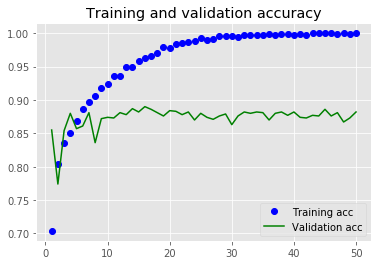

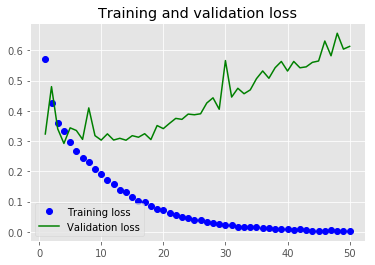

In [14]:
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

References:

1. [Anthony Tanbakuchi](http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/ )







